# Decoders

The aim of this notebook is to test different architectures with fixed encoder (resnet34). The following architectures will be tested:

- [Unet](https://arxiv.org/abs/1505.04597)
- [Unet++](https://arxiv.org/pdf/1807.10165.pdf)
- [MAnet](https://ieeexplore.ieee.org/abstract/document/9201310)
- [PSPNet](https://arxiv.org/abs/1612.01105)
- [DeepLabV3](https://arxiv.org/abs/1706.05587)
- [DeepLabV3+](https://arxiv.org/abs/1802.02611)

## Google Colab

The first cell will only be run in Google Colab, the second one locally as well.

In [1]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
import os
import glob

# let's keep this cell at the beginning for every notebook
# for more convenient training in Google Colab
def get_root_path(filename: str) -> str: 
    """Get root path based on notebook's name."""
    filepath = glob.glob(os.getcwd() + '/**/' + filename, recursive = True)[0]
    return os.path.dirname(os.path.dirname(filepath))

ROOT_PATH = get_root_path('decoders.ipynb')
sys.path.append(ROOT_PATH)

# go to the drive directory
os.chdir(ROOT_PATH) if IN_COLAB else None

## Imports

In [3]:
import os
import cv2
import torch

import albumentations as A
import segmentation_models_pytorch as smp

from sklearn.model_selection import KFold
from scripts.evaluation import EvaluationMonitor, get_best_f1_per_setup
from scripts.preprocessing import RoadDataset, split_data
from scripts.training import train_model
from torch.utils.data import DataLoader, SubsetRandomSampler

## Data

In [4]:
# specify train directory
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

In [5]:
# image paths so that all the images are used for train dataset (no test set for cv due to small training set)
image_path_train, _, mask_path_train, _ = split_data(train_directory, test_size=0)

# create train Dataset without transformations for now
train_dataset = RoadDataset(image_path_train, mask_path_train)

In [6]:
# define transformations
train_tf = A.Compose([
    A.Resize(height=608, width=608, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5, limit=180, border_mode=cv2.BORDER_CONSTANT, rotate_method="ellipse"),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomSnow(p=0.1)
])

valid_tf = A.Compose([A.Resize(height=608, width=608, always_apply=True)])

## Models

Define models, that we're going to use and create monitor object for later evaluation.
('Unet', 'UnetPlusPlus', 'MAnet', 'PSPNet', 'DeepLabV3', 'DeepLabV3Plus')

In [7]:
# specify the root path for evaluation json-s
evaluation_dir = os.path.join(ROOT_PATH, 'data', 'results', 'decoder')
monitor = EvaluationMonitor(evaluation_dir)
models = monitor.get_not_updated_models()

## Hyperparameters

Since our aim is to see, how different architectures influence the training, we fix the model, epochs and batch sizes.

In [8]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'

SEED = 16
BATCH_SIZE = 4
K_FOLD = 5
N_CPU = os.cpu_count()
N_EPOCHS = 150

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE,
    'num_workers': N_CPU,
    'persistent_workers': True
}

## Cross-Validation

In [9]:
for model_name in models:

    print(f'model: {str(model_name)}')

    k_fold = KFold(n_splits=K_FOLD, shuffle=True, random_state=SEED)

    # Record K-fold results in a (K_FOLD, num_epoch) matrix
    training_loss_matrix = []
    validation_loss_matrix = []
    training_f1_matrix = []
    validation_f1_matrix = []

    # Get training and validation indices
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):

        print(f'fold: {fold}')

        # Create training and validation loaders by providing current K-Fold train/validation indices to Sampler
        train_loader = DataLoader(train_dataset.set_tf(train_tf), sampler=SubsetRandomSampler(train_idx), **LOADER_PARAMS)
        valid_loader = DataLoader(train_dataset.set_tf(valid_tf), sampler=SubsetRandomSampler(val_idx), **LOADER_PARAMS)

        # Initialize model
        model_ = smp.create_model(model_name, encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)
        criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)
        scheduler_ = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_,
            T_max=(len(train_loader.dataset) * N_EPOCHS) // train_loader.batch_size,
        )

        # Train model
        train_losses, valid_losses, train_f1s, valid_f1s = train_model(
            model_, (train_loader, valid_loader), criterion_, optimizer_, scheduler_, N_EPOCHS
        )

        # Save epoch results
        training_loss_matrix.append(train_f1s)
        validation_loss_matrix.append(train_f1s)
        training_f1_matrix.append(train_f1s)
        validation_f1_matrix.append(valid_f1s)
    
    monitor.update_metrics(
        model_name,
        training_f1=training_f1_matrix,
        training_loss=training_loss_matrix,
        validation_f1=validation_f1_matrix,
        validation_loss=validation_loss_matrix
    )
    monitor.update_jsons()

## Metrics

CV was run on colab, the results saved to JSON, and now we can start analysing them.

In [10]:
stats_df = get_best_f1_per_setup(monitor.metrics['validation_f1'])
stats_df

,top_f1,std_dev
Unet,0.857770,0.018616
UnetPlusPlus,0.858632,0.023208
MAnet,0.846017,0.032416
PSPNet,0.826700,0.036219
DeepLabV3,0.860264,0.017905
DeepLabV3Plus,0.857683,0.020758


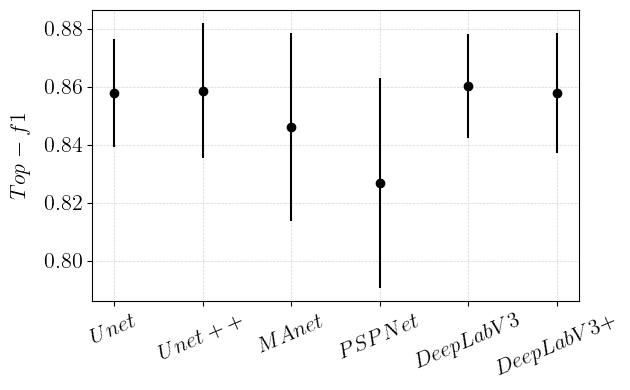

In [17]:
from distutils.spawn import find_executable
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6.4, 4.))

plt.rc('text', usetex=bool(find_executable('latex')))
stats_df.rename(index={'UnetPlusPlus': 'Unet++', 'DeepLabV3Plus': 'DeepLabV3+'}, inplace=True)

x_labels = [r'${}$'.format(s) for s in stats_df.index.tolist()]

plt.errorbar(x_labels, stats_df.top_f1, stats_df.std_dev, linestyle='None', marker='o', color='black')
plt.grid(color="#d3d3d3", linestyle="--", linewidth=0.5)
plt.ylabel(r'$Top-f1$', fontsize=16, labelpad=10)

_ = plt.xticks(fontsize=16, rotation='23')
_ = plt.yticks(fontsize=16)

plt.tight_layout()

plt.savefig('architecture.png', dpi=600)